In [199]:
# 2024.11.19
# use scan inputs + fixed thresholds to build behavior model
# use random inputs for validation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PySpice.Logging.Logging as Logging


from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Unit import *
from PySpice.Spice.HighLevelElement import PulseMixin
from PySpice.Spice.Simulation import CircuitSimulator


# Standard Libraries
import os
import numpy as np 
import pandas as pd 
import random as rn
# import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset

# Visualization libraries
# import pydotplus
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
# sns.set_style({"axes.facecolor": ".95"})

# Modeling and Machine Learning
from IPython.display import Image 
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
# from sklearn.externals.six import StringIO  
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import tensorflow as tf
from scipy.optimize import  curve_fit

from joblib import dump, load
import time
from tqdm import tqdm 
# from SDT_simple import SDT
# from SDT import SDT
from tensorflow.python.keras.utils import np_utils
import optuna

2024-12-01 10:04:38.884484: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 10:04:38.884517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 10:04:38.885793: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 10:04:38.891430: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-01 10:04:39.451047: W tensorflow/compiler/tf2

In [2]:
# Seed for reproducability
seed = 1024
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
#
logger = Logging.setup_logging()
# libraries_path = find_libraries()
libraries_path = '/ltspice/lib/'
spice_library = SpiceLibrary(libraries_path)

In [3]:

def sigmoid(x,k,c):
    y = 1/(1+np.exp(-1*k*(x-c)))
    # y = y*0.875-0.065
    return y



def row_fitting(a,p,b,col_num=0):
    
    p_pro = 1
    p_sum = 0
    # b=1-a
    # if col_num==0:
    for i in  range(int(col_num)):
        p_pro = p_pro*p[:,i]
        p_sum = p_sum + p[:,i]
    P = a*p_pro+b*p_sum-b*(col_num-1)

    P[P<=0]=0
    P[P>=1]=1
    
    return P
    
def func(x, a, b):
    return a * x + b

def plot_sample(plot_data,threshold=0.1):
    # time_index = (plot_data[plot_data['input']==all_match_row_index]['ML(V)']-threshold).abs().idxmin()
    # t_sample = plot_data[plot_data['input']==all_match_row_index]['time'][time_index]
    time_index = (plot_data[plot_data['input']==1]['ML(V)']-threshold).abs().idxmin()
    t_sample = plot_data[plot_data['input']==1]['time'][time_index]
    # t_sample = 1
    V_ML_sample=pd.DataFrame()
    # for t_sample in np.arange(4,5,1):

    V_ML_temp=[]
    
    for V_s in np.arange(-1,1.0001,0.001):
    # for V_s in range(1000):
        data_temp = plot_data[plot_data['input']==np.round(V_s,2)]
        # data_temp = plot_data[(plot_data['input']-Vg_temp<0.01)&(plot_data['input']-Vg_temp>-0.01)]
        data_temp = data_temp.reset_index(drop=True)
        if len(data_temp)==0:
            continue
        # print(data_temp[np.abs(data_temp['time']-t_sample)==np.min(np.abs(data_temp['time']-t_sample))])
        V_ML_temp.append([np.round(V_s,2),data_temp.iloc[(data_temp['time']-t_sample).abs().idxmin()]['ML(V)']])
    V_ML_temp = pd.DataFrame(V_ML_temp,columns=['input','ML(V)'])
    V_ML_temp['t_sample']=np.round(t_sample,2)
    V_ML_sample = pd.concat((V_ML_sample,V_ML_temp),axis=0,ignore_index=True)
    
    # ax1 = sns.scatterplot(data=V_ML_sample,x='input',y='ML(V)',hue='t_sample',legend='full')
    # ax2 = sns.lineplot(data=V_ML_sample,x='input',y='ML(V)',hue='t_sample',legend=False,linewidth=2)
    sns.histplot(data=V_ML_sample,x='ML(V)',hue='t_sample',kde=True,bins=20)
    # plt.plot()
    # print(ax1.get_legend_handles_labels())
    # plt.xlim([-3.35,-2.55])
    plt.xlabel('ML(V)',fontsize=6,labelpad=0)
    plt.ylabel('Count',fontsize=6,labelpad=0)
    plt.legend('', frameon=False)
    # plt.colorbar()
    # plt.legend(['0.2','0.3','0.4','0.5','0.6','0.7','0.8'])
    return V_ML_sample,t_sample


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:29<00:00, 29.25s/it]


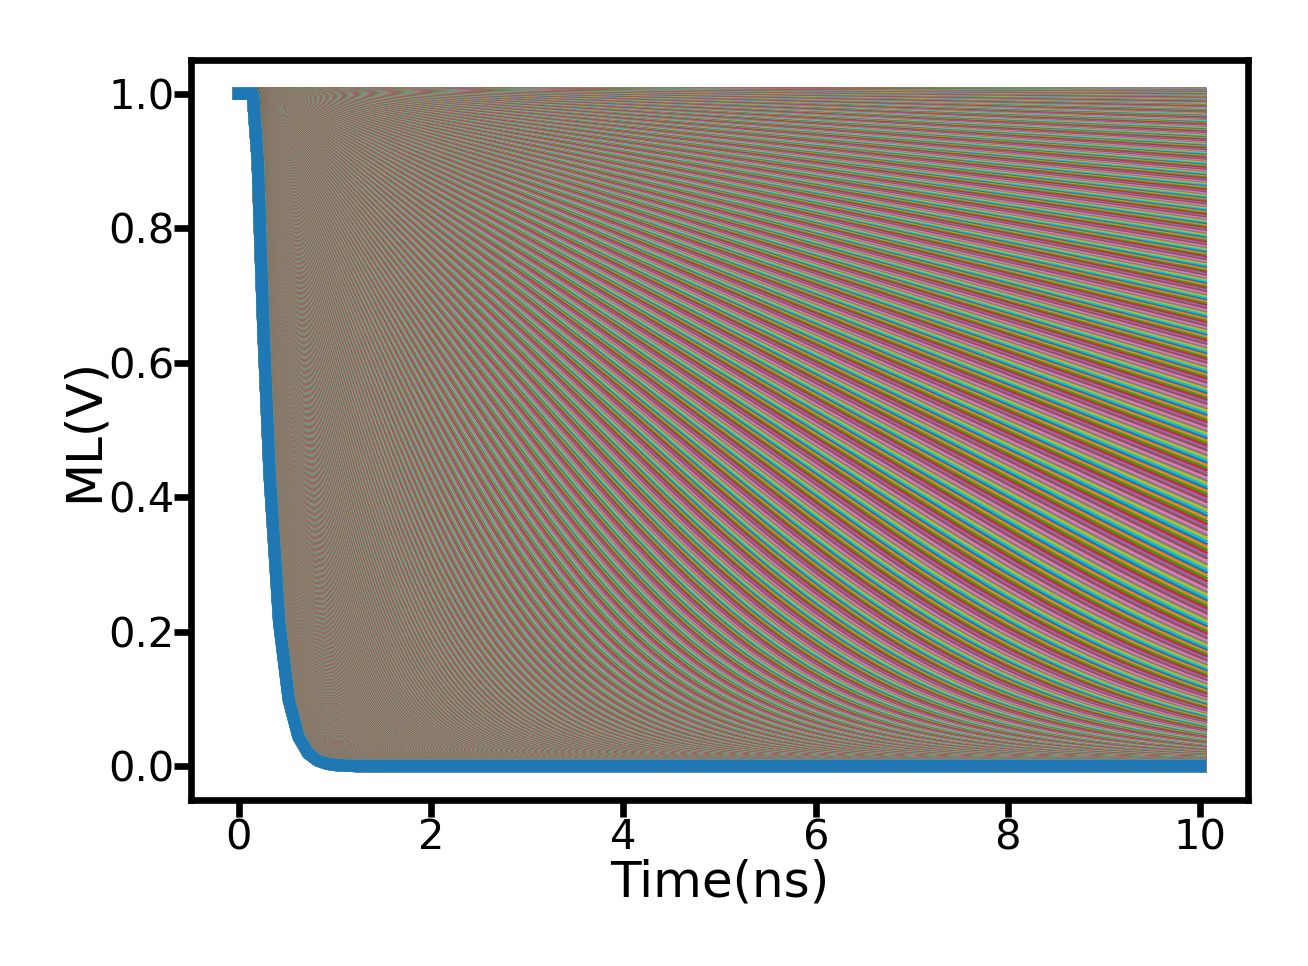

In [620]:
Is_row_list=[1e-8,1e-9,1e-10,1e-11,1e-13]
On_off_list = ['3','4','5','6','7']
# noise_level = 0.1
rmse_all = []
# for Cols_Num_power in np.arange(3,10):
# for noise_level in tqdm([0,0.01,0.05,0.1,0.2,0.5]):
for noise_level in tqdm([0]):
    for Cols_Num_power in tqdm(np.arange(3,3.5,1)):
        
        for index in tqdm(np.arange(0,0.5,1)):
            ML_all = pd.DataFrame()
            
            Rows_Num = 1
            Cols_Num = int(np.power(2,Cols_Num_power))
            V_offset=0
            C_ml=125*Cols_Num*1e-18
            # C_ml=500*1e-12
            C_ml_old = C_ml*124.3649414
            K=1e-6 
            # K = 8e-4
            W=20e-6 
            L=7e-9 
            KP = K/W*L  
            # KP_old = 1e-6/W*L
            Vt_0=0
            Is_set = Is_row_list[4]


            # Vt_array = np.array([
            #     # [3.3,3.3,3.3,3.3,3.3,3.3,3.3,3.3],
            #     [0,3.3,0,3.3,0,3.3,0,3.3]
            #     # [-1,-1,-1,-1,-1,-1,-1,-1]
            # ])-0.5
            # Vt_array = np.ones([1,int(Cols_Num)])*(0.0)
            Vt_array = np.arange(-1,1.01,2/int(Cols_Num-1))
            Vt_array = Vt_array.reshape(1,-1)
            # if Cols_Num_power>2:
            #     for i in range(int(Cols_Num_power-2)):
            #         Vt_array = np.concatenate((Vt_array,Vt_array),1)

            # Vsl_array = np.ones([1, int(Cols_Num)])*(-1)
            Vsl_array = np.random.randn(1000, Cols_Num)*0.33
            # for kk in range(np.power(2,int(Cols_Num_power-np.minimum(4,Cols_Num_power)))):
            #     Vt_array[0,kk*2]=-0.5



            # Vt_array = Vt_array + np.random.randn(Vt_array.shape[0],Vt_array.shape[1])*noise_level
            circuit = Circuit('Analog CAM array '+str(Rows_Num)+' by '+str(Cols_Num))
            
            Is_row = Is_set                    
            for i in np.arange(Rows_Num):
                circuit.C('_'+str(i),'ML'+str(i),circuit.gnd,C_ml)

                for cc in range(int(Cols_Num/2)):
                    circuit.M('P_'+str(i)+str(cc), 'ML'+str(i),'CTL', 'VCC', 'VCC', model='P1')
                if Cols_Num<2:
                    circuit.M('P_'+str(i), 'ML'+str(i),'CTL', 'VCC', 'VCC', model='P1')

                # circuit.R('R_'+str(i), 'ML'+str(i), circuit.gnd,1e8*1@u_kΩ)
                
                for j in np.arange(Cols_Num):
                    j = int(j)
                        
                    # circuit.model('NMOS_'+'L'+str(i)+'_'+str(j), 'NMOS', KP=KP, W=20e-6, L=7e-9, RS=0, Rd=0, VTO=Vt_array[i,int(j*2)], Lambda=0.022306813197742, Ksubthres=250e-5, Is=Is_row, mtriode=0.95)
                    # circuit.model('NMOS_'+'R'+str(i)+'_'+str(j), 'NMOS', KP=KP, W=20e-6, L=7e-9, RS=0, Rd=0, VTO=Vt_array[i,int(j*2+1)], Lambda=0.022306813197742, Ksubthres=250e-5, Is=Is_row, mtriode=0.95)
                    circuit.model('NMOS_'+'L'+str(i)+'_'+str(j), 'NMOS', KP=KP, W=20e-6, L=7e-9, RS=0, Rd=0, VTO=Vt_array[i,j], Lambda=0.022306813197742, Ksubthres=250e-5, Is=Is_row, mtriode=0.95)
                    circuit.model('NMOS_'+'R'+str(i)+'_'+str(j), 'NMOS', KP=KP, W=20e-6, L=7e-9, RS=0, Rd=0, VTO=3.3, Lambda=0.022306813197742, Ksubthres=250e-5, Is=Is_row, mtriode=0.95)
                    circuit.M('_'+'L'+str(i)+'_'+str(j),'ML'+str(i),'SL'+str(j),circuit.gnd,circuit.gnd,model='NMOS_'+'L'+str(i)+'_'+str(j))
                    circuit.M('_'+'R'+str(i)+'_'+str(j),'ML'+str(i),'SL_bar'+str(j),circuit.gnd,circuit.gnd,model='NMOS_'+'R'+str(i)+'_'+str(j))
                    if i==0:
                            circuit.PulseVoltageSource('V_SL_'+str(j),'SL'+str(j),circuit.gnd,initial_value = -3,pulsed_value=Vsl_array[0,j],pulse_width=14.9@u_ns,period=15@u_ns,delay_time=.1@u_ns)
                            circuit.PulseVoltageSource('V_SL_bar_'+str(j),'SL_bar'+str(j),circuit.gnd,initial_value = -3,pulsed_value=V_offset -Vsl_array[0,j],pulse_width=14.9@u_ns,period=15@u_ns,delay_time=.1@u_ns)
            circuit.PulseVoltageSource('ctl','CTL',circuit.gnd,initial_value=-5,pulsed_value=5,pulse_width=14.9@u_ns,period=15@u_ns,delay_time=.1@u_ns)
            circuit.V('cc','VCC',circuit.gnd,1)
            circuit.model('P1', 'PMOS')
            legend_list=[]
            
            fig, ax = plt.subplots(dpi=600,figsize=(2.28,1.71),layout='tight')
            plt.rcParams["svg.fonttype"]='none'
            plt.rcParams["font.family"]='Helvetica'
            plt.rcParams["savefig.transparent"]=True
            # Vsl_array_all = []
            all_match_row_mean = 100
            for V_s in np.arange(-1,1.0001,0.001):
            # for V_s in range(1000):
                Vsl_array = np.ones([1, int(Cols_Num)])*V_s
                
                # Vsl_array_all.append(Vsl_array[0,:])
                for j in np.arange(Cols_Num):
                    j = int(j)
                    circuit['VV_SL_'+str(j)].pulsed_value = Vsl_array[0,j]@u_V
                    circuit['VV_SL_bar_'+str(j)].pulsed_value = V_offset - Vsl_array[0,j]@u_V
                

                simulator = circuit.simulator(temperature=25, nominal_temperature=25)
                analysis = simulator.transient(step_time=0.1@u_ns,end_time=10@u_ns)
                
                ML_rows = pd.DataFrame()
                for ii in np.arange(Rows_Num):
                    
                    t_temp = pd.DataFrame(analysis.time*1e9)                                                 
                    t_temp.columns = ['time']
                    if ii==0:
                    
                        plt.plot(t_temp['time'],analysis['ML'+str(ii)])
                    
                    # else:
                    #     sns.lineplot(x=t_temp['time'],y=analysis['ML'+str(ii)] ,linestyle='dashed',color='black')

                    V_temp = pd.DataFrame(analysis['ML'+str(ii)])
                    V_temp.columns = ['ML(V)']
                    if V_temp['ML(V)'].mean()<all_match_row_mean:
                        all_match_row_index = V_s
                        all_match_row_mean = V_temp['ML(V)'].mean()
                    ML_temp = pd.concat((t_temp,V_temp),axis=1)
                    # ML_temp['ML']=ii
                    ML_temp['Column#']=Cols_Num
                    ML_rows = pd.concat((ML_rows,ML_temp),axis=0,ignore_index=True)
                    legend_list.append('ML'+str(ii+1))

                ML_rows['input']=np.round(V_s,2)
                ML_all = pd.concat((ML_all,ML_rows),axis=0,ignore_index=True)

            # data_sample = plot_sample(ML_all[ML_all['ML']==0])
            plt.xlabel('Time(ns)',fontsize=6,labelpad=0)
            plt.ylabel('ML(V)',fontsize=6,labelpad=0)
            ax.tick_params(axis='y', which='major', length=2,pad=0,labelsize=5)
            ax.tick_params(axis='x', which='major', length=2,pad=0.2,labelsize=5)
            # plt.xlim([0,1])
        


0.4199999999999997


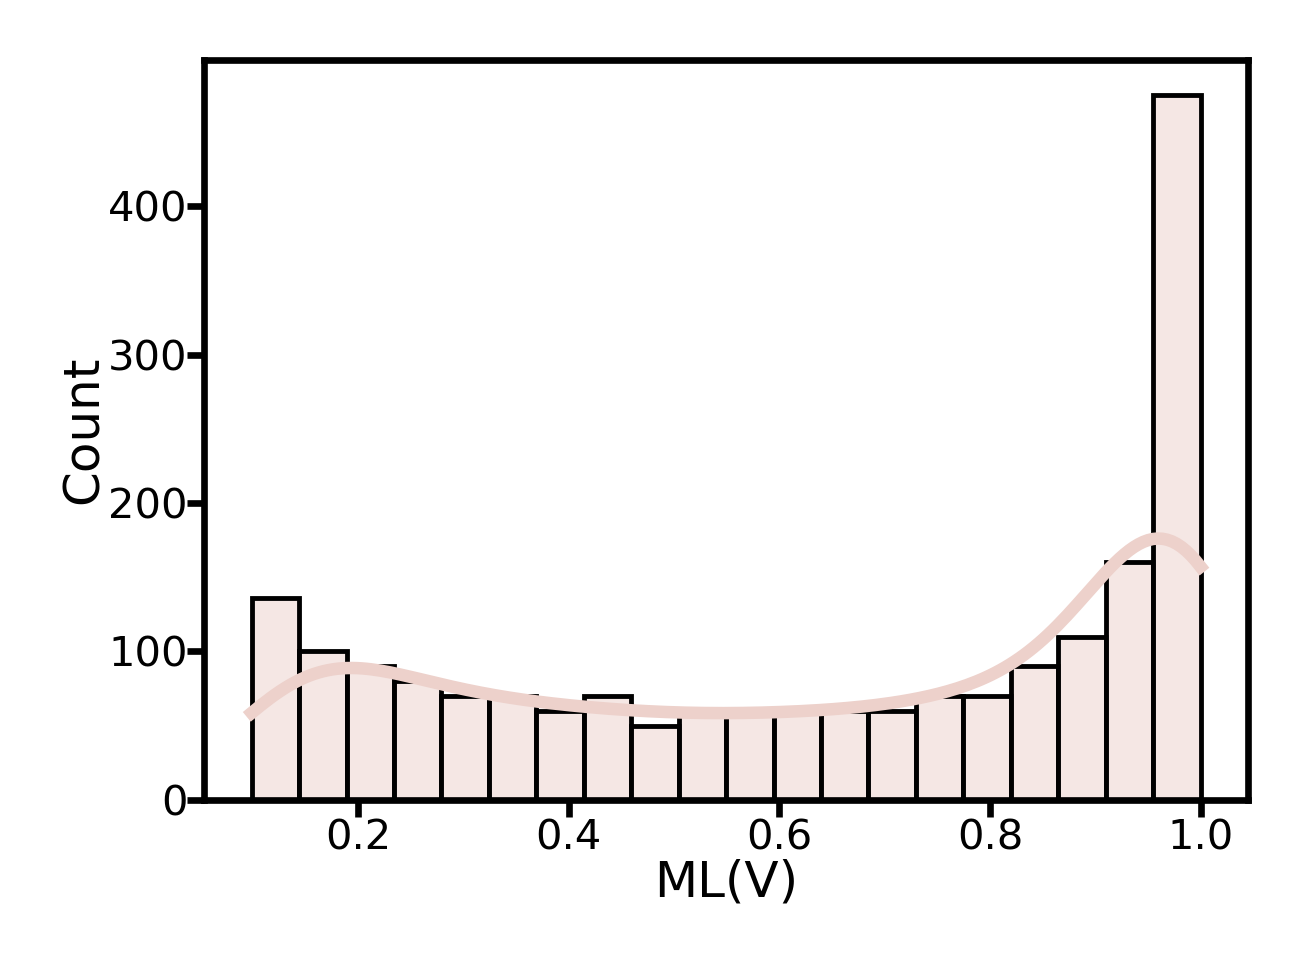

In [622]:

plt.rcParams["svg.fonttype"]='none'
plt.rcParams["font.family"]='Helvetica'
plt.rcParams["savefig.transparent"]=True
fig, ax = plt.subplots(dpi=600,figsize=(2.28,1.71),layout='tight')
data_sample,t_sample = plot_sample(ML_all)
# plt.xlabel('Time(ns)',fontsize=6,labelpad=0)
# plt.ylabel('ML(V)',fontsize=6,labelpad=0)
ax.tick_params(axis='y', which='major', length=2,pad=0,labelsize=5)
ax.tick_params(axis='x', which='major', length=2,pad=0.2,labelsize=5)
print(t_sample-0.1)

In [623]:
data_sample['ML(V)'].min()

0.09901104891099681

In [625]:
data_sample['ML(V)']

0       0.999994
1       0.999994
2       0.999994
3       0.999994
4       0.999994
          ...   
1996    0.099011
1997    0.099011
1998    0.099011
1999    0.099011
2000    0.099011
Name: ML(V), Length: 2001, dtype: float64

In [626]:
Vsl_array_all = np.arange(-1,1.0001,0.001).reshape(-1,1)*np.ones([1,int(Cols_Num)])
Vsl_array_all

array([[-1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
       [-0.999, -0.999, -0.999, ..., -0.999, -0.999, -0.999],
       [-0.998, -0.998, -0.998, ..., -0.998, -0.998, -0.998],
       ...,
       [ 0.998,  0.998,  0.998, ...,  0.998,  0.998,  0.998],
       [ 0.999,  0.999,  0.999, ...,  0.999,  0.999,  0.999],
       [ 1.   ,  1.   ,  1.   , ...,  1.   ,  1.   ,  1.   ]])

In [627]:
Vsl_array_all.shape

(2001, 8)

In [495]:
Vt_array.shape

(1, 8)

In [ ]:

def objective1(trial):

    # k_best = trial.suggest_uniform('k',-9,-7)
    k_best = trial.suggest_float('k',-3,-2,step=0.1)
    # c_offset = trial.suggest_uniform('c',0,1.5)
    c_offset = trial.suggest_float('c',1,2,step=0.1)
    p_cells =sigmoid(x=Vsl_array_all,k=k_best,c=Vt_array+c_offset)
    a = trial.suggest_float('a',0,1,step=0.1)
    # a = 1
    b = trial.suggest_float('b',0,1,step=0.1)
    # b = 0
    y_fit = row_fitting(a,p_cells,b,col_num=int(Cols_Num))
    error = np.power((y_fit-data_sample['ML(V)']),2).mean()
    # error = (y_fit-data_sample['ML(V)']).abs().mean()
    # error =  np.power((y_fit[data_sample['ML(V)'].values>0.5]-data_sample['ML(V)'].values[data_sample['ML(V)'].values>0.5]),2).mean()
    return error

def objective2(trial):

    # k_best = trial.suggest_uniform('k',-9,-7)
    # k_best = k_best_best
    k_best = trial.suggest_float('k',k_best_best-0.1,k_best_best+0.1,step=0.01)
    # c_offset = trial.suggest_uniform('c',0,1.5)
    # c_offset = c_best
    c_offset = trial.suggest_float('c',c_best-0.1,c_best+0.1,step=0.01)
    p_cells =sigmoid(x=Vsl_array_all,k=k_best,c=Vt_array+c_offset)
    # a = trial.suggest_uniform('a',0,1)
    a = trial.suggest_float('a',0,1.0,step=0.01)
    # b = trial.suggest_uniform('b',0,1)
    b = trial.suggest_float('b',0,1,step=0.01)
    y_fit = row_fitting(a,p_cells,b,col_num=int(Cols_Num))
    error = np.power((y_fit-data_sample['ML(V)']),2).mean()
    # error = (y_fit-data_sample['ML(V)']).abs().mean()
    # error =  np.power((y_fit[data_sample['ML(V)'].values>0.5]-data_sample['ML(V)'].values[data_sample['ML(V)'].values>0.5]),2).mean()
    return error
study1 = optuna.create_study(direction='minimize')
study1.optimize(objective1, n_trials=1000)
k_best_best = study1.best_params['k']
c_best = study1.best_params['c']
study2 = optuna.create_study(direction='minimize')
study2.optimize(objective2, n_trials=1000)

    

/tmp/ipykernel_3990337/3199524433.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  a = trial.suggest_uniform('a',0,1)
/tmp/ipykernel_3990337/3199524433.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  b = trial.suggest_uniform('b',0,1)


/home/wenbo/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:693: UserWarning: The distribution is specified by [-2.3000000000000003, -2.1] and step=0.01, but the range is not divisible by `step`. It will be replaced by [-2.3000000000000003, -2.1].
  warnings.warn(
/home/wenbo/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:693: UserWarning: The distribution is specified by [1.7, 1.9000000000000001] and step=0.01, but the range is not divisible by `step`. It will be replaced by [1.7, 1.9].
  warnings.warn(


In [667]:
k_best_best = study2.best_params['k']
c_best = study2.best_params['c']

a_best = study2.best_params['a']
b_best = study2.best_params['b']
p_cells =sigmoid(x=Vsl_array_all,k=k_best_best,c=Vt_array[0,:]+c_best)
P_fit = row_fitting(a_best,p_cells,b_best,col_num=int(Cols_Num))
# print( "%.4f %.4f %.4f %.4f"  % (k_best_best , c_best  ,a_best ,b_best))
print(study1.best_params)
print(t_sample)
study2.best_params


{'k': -2.2, 'c': 1.8, 'a': 0.9756657742609802, 'b': 0.06201781828764882}
0.5199999999999997


{'k': -2.22, 'c': 1.75, 'a': 1.0, 'b': 0.05}

In [668]:
# 
P_product = np.product(p_cells,axis=1)
P_product = pd.DataFrame(P_product,columns=['P_product'])
P_predict = pd.DataFrame(P_fit,columns=['P_predict'])
data_analysis = pd.concat((data_sample,P_product),axis=1)
data_analysis = pd.concat((data_analysis,P_predict),axis=1)

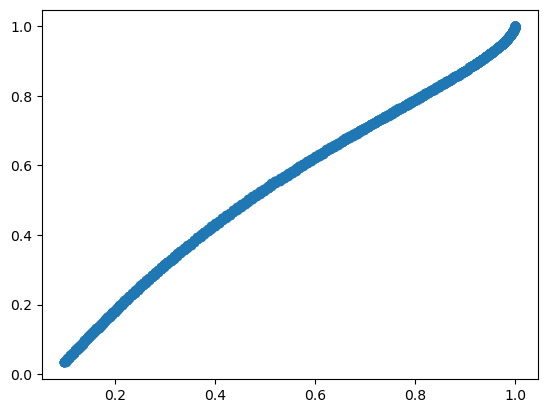

In [669]:
plt.scatter(data_sample['ML(V)'],P_fit)

rmse= 0.02530690867857243
r2= 0.9939576206395924
0.025307069679457925


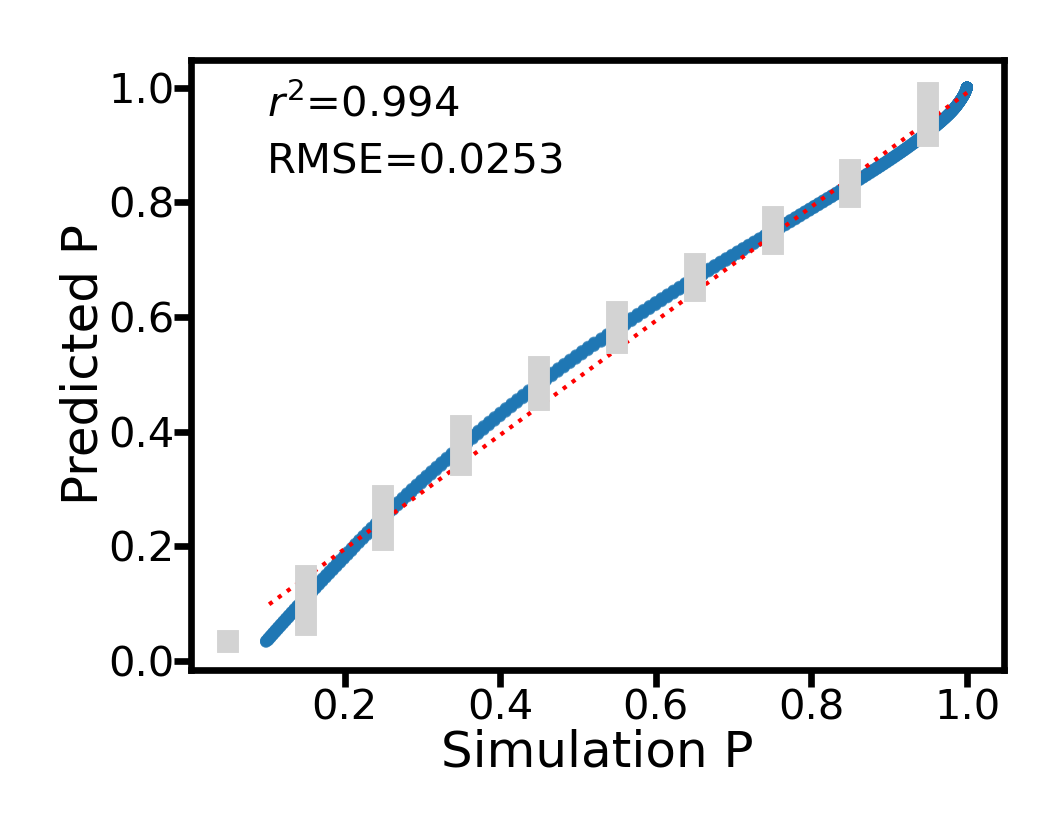

In [670]:
y_fit = P_fit
y = y_fit
P_row = data_sample['ML(V)']
x = P_row
params, _ = curve_fit(func, P_row, y_fit)
a, b = params[0], params[1]
y_line_fit = func(P_row, a, b)

a, b = np.polyfit(x, y, deg=1)
y_est = a * x + b


y_err = x.std() * np.sqrt(1/len(x) +
                          (x - x.mean())**2 / np.sum((x - x.mean())**2))

plt.rcParams["svg.fonttype"]='none'
plt.rcParams["font.family"]='Helvetica'
plt.rcParams["savefig.transparent"]=False
fig, ax = plt.subplots(dpi=600,figsize=(1.76,1.32))
ax.set_box_aspect(1.32/1.76)
# plt.figure(dpi=300)
# ax.plot(P_row,y_line_fit,ls=':',color='r',linewidth=1)
# ax.plot(x, y_est, ':r',linewidth=0.5)
ax.plot(x, y_line_fit, ':r',linewidth=0.5)
# ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.3)

ax.scatter(x=P_row,y=y_fit,s=2,alpha=0.5,edgecolor='none')
sns.regplot(x=P_row,y=y_fit,marker=True,fit_reg=False,color='lightgrey',x_bins=np.arange(0.05, 1.05, 0.1),x_ci='sd',ax=ax,ci=95,line_kws={'linewidth':1.5,'alpha':0.8},scatter_kws={'s':1},n_boot=10)
# sns.scatterplot(x=P_row,y=y_fit)
r = np.corrcoef(y_fit,P_row)
rmse = np.sqrt(np.power((y_fit-P_row),2).mean())

print('rmse=',rmse)
print('r2=',r[0,1]**2)

plt.ylabel('Predicted P',fontsize=6,labelpad=0)
plt.xlabel('Simulation P',fontsize=6,labelpad=0)
ax.tick_params(axis='y', which='major', length=2,pad=0,labelsize=5)
ax.tick_params(axis='x', which='major', length=2,pad=0.2,labelsize=5)
plt.text(0.1,0.95*P_row.max(),'$r^2$='+str(np.round(r[0,1]**2,4)),fontsize=5)
plt.text(0.1,0.85*P_row.max(),'RMSE='+str(np.round(rmse,4)),fontsize=5)
print(rmse/P_row.max())

In [683]:
Cols_Num = int(Cols_Num)
# Vsl_array_rand = np.random.rand(1000, Cols_Num)*1-0.5
Vsl_array_rand = np.random.randn(1000, Cols_Num)*0.33
# Vsl_array_rand = np.random.randn(1000, 1)*np.ones([1,Cols_Num])*0.3
Vsl_array_rand

array([[ 0.0619507 , -0.49881204,  0.53231074, ..., -0.18701285,
         0.21924946,  0.51964934],
       [-0.57088658,  0.75849351, -0.0579069 , ...,  0.4426761 ,
         0.08798966, -0.01679173],
       [-0.3230677 ,  0.06874447,  0.08334585, ...,  0.22349915,
         0.58657758, -0.30442865],
       ...,
       [-0.50550488, -0.31048181, -0.16185315, ...,  0.04942261,
        -0.37433574, -0.28830107],
       [ 0.29775746,  0.07118021, -0.41405872, ...,  0.1239773 ,
        -0.37730423,  0.43979971],
       [ 0.2920605 ,  0.28096691, -0.29271355, ...,  0.25201279,
        -0.39270808,  0.46394095]])

In [684]:
np.save('Vsl_array_rand_'+str(Cols_Num)+'.npy',Vsl_array_rand)

In [685]:
Vsl_array_rand = np.load('Vsl_array_rand_'+str(Cols_Num)+'.npy')

In [686]:
Vsl_array_rand

array([[ 0.0619507 , -0.49881204,  0.53231074, ..., -0.18701285,
         0.21924946,  0.51964934],
       [-0.57088658,  0.75849351, -0.0579069 , ...,  0.4426761 ,
         0.08798966, -0.01679173],
       [-0.3230677 ,  0.06874447,  0.08334585, ...,  0.22349915,
         0.58657758, -0.30442865],
       ...,
       [-0.50550488, -0.31048181, -0.16185315, ...,  0.04942261,
        -0.37433574, -0.28830107],
       [ 0.29775746,  0.07118021, -0.41405872, ...,  0.1239773 ,
        -0.37730423,  0.43979971],
       [ 0.2920605 ,  0.28096691, -0.29271355, ...,  0.25201279,
        -0.39270808,  0.46394095]])

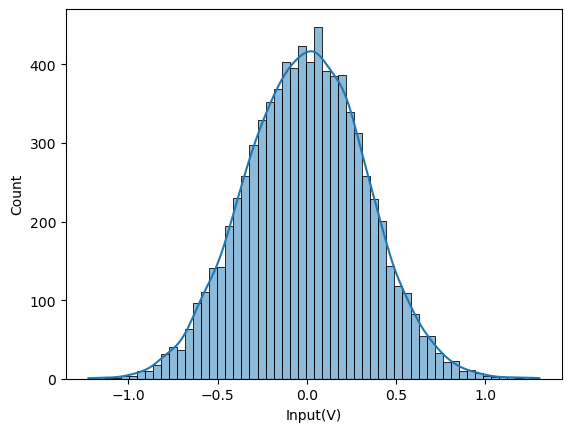

In [687]:
sns.histplot(Vsl_array_rand.reshape(-1,1),kde=True)
plt.xlabel('Input(V)')
plt.legend('', frameon=False)


In [688]:
# Vt_array = np.ones([1,int(Cols_Num)])*(0.2)
# Vt_array_noise = Vt_array + np.random.randn(Vt_array.shape[0],Vt_array.shape[1])*noise_level

In [750]:
Vt_array_noise_generate = np.random.randn(Vt_array.shape[0],Vt_array.shape[1])

In [751]:
# np.save('Vsl_array_rand_'+str(Cols_Num)+'.npy',Vsl_array_rand)

In [752]:
data_analysis_all = pd.DataFrame()
ML_all_rand_all = pd.DataFrame()
for noise_level in tqdm([0,0.1,0.2,0.3,0.4,0.5]):
# for noise_level in tqdm([0]):
    # Vt_array = np.ones([1,int(Cols_Num)])*(0.0)
    Vt_array_noise = Vt_array + Vt_array_noise_generate*noise_level

    for j in range(Cols_Num):
        circuit._models['NMOS_'+'L0_'+str(j)]._parameters['VTO']=Vt_array_noise[0,j]
    
    ML_all_rand = pd.DataFrame()
    for i in range(1000):
        for j in np.arange(Cols_Num):

            circuit['VV_SL_'+str(j)].pulsed_value = Vsl_array_rand[i,j]@u_V
            circuit['VV_SL_bar_'+str(j)].pulsed_value = V_offset - Vsl_array_rand[i,j]@u_V



        simulator = circuit.simulator(temperature=25, nominal_temperature=25)

        analysis = simulator.transient(step_time=0.1@u_ns,end_time=10@u_ns)

        legend_list=[]
        ML_rows = pd.DataFrame()

        for ii in np.arange(Rows_Num):
        # for ii in [0]:
            
            t_temp = pd.DataFrame(analysis.time*1e9) 
            
            
            t_temp.columns = ['time']
            # if ii==3:
            #     continue
            # if ii==0:
            
            #     plt.plot(t_temp['time'],analysis['ML'+str(ii)])
            
            # else:
            #     sns.lineplot(t_temp['time(ms)'],analysis['ML'+str(ii)] ,linestyle='dashed',color='black')

            V_temp = pd.DataFrame(analysis['ML'+str(ii)])
            
            V_temp.columns = ['ML(V)']
            # if V_temp['ML(V)'].mean()<all_match_row_mean:
            #     all_match_row_index = i
            #     all_match_row_mean = V_temp['ML(V)'].mean()
            ML_temp = pd.concat((t_temp,V_temp),axis=1)
            ML_temp['index']=i

            ML_temp['Column#']=Cols_Num
            ML_rows = pd.concat((ML_rows,ML_temp),axis=0,ignore_index=True)
            legend_list.append('ML'+str(ii+1))
        # if ii>16:
        #     break
    # ML_rows['input']=V_s
        ML_all_rand = pd.concat((ML_all_rand,ML_rows),axis=0,ignore_index=True)
    ML_all_rand['noise level']=noise_level
    ML_all_rand_all = pd.concat((ML_all_rand_all,ML_all_rand),axis=0,ignore_index=True)
    
    
    data_random_sample = pd.DataFrame()
    for i in range(1000):
        V_temp =ML_all_rand.iloc[(ML_all_rand[ML_all_rand['index']==i]['time']-t_sample).abs().idxmin()]['ML(V)']
        data_temp = pd.DataFrame([V_temp])
        data_temp.columns=['ML(V)']
        data_temp['index']=i
        data_random_sample = pd.concat((data_random_sample,data_temp),axis=0)
    data_random_sample = data_random_sample.reset_index(drop=True)
    p_cells_rand =sigmoid(x=Vsl_array_rand,k=k_best_best,c=Vt_array[0,:]+c_best)
    P_fit_rand = row_fitting(a_best,p_cells_rand,b_best,col_num=int(Cols_Num))
    P_product_rand = np.product(p_cells_rand,axis=1)
    P_product_rand = pd.DataFrame(P_product_rand,columns=['P_product'])
    P_predict_rand = pd.DataFrame(P_fit_rand,columns=['P_predict'])
    data_analysis_rand = pd.concat((data_random_sample,P_predict_rand),axis=1)
    # data_analysis_rand = pd.concat((data_analysis_rand,P_predict_rand),axis=1)
    data_analysis_rand['noise_level'] = noise_level
    data_analysis_all = pd.concat((data_analysis_all,data_analysis_rand),axis=0)

100%|██████████| 6/6 [01:50<00:00, 18.38s/it]


In [753]:
# ML_all_rand_all = pd.read_csv('ML_all_rand_all_1024_t_1.csv')

In [754]:
# data_analysis_all = pd.read_csv('data_analysis_all_1024_t_1.csv')

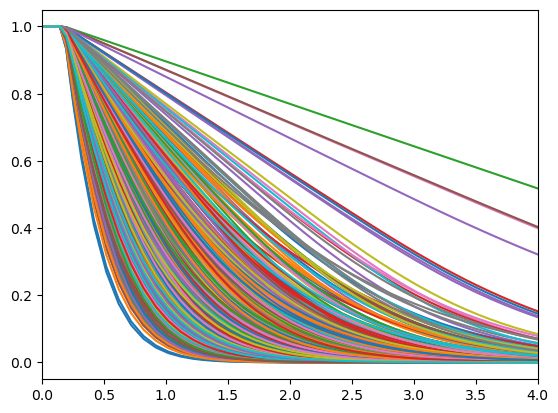

In [755]:
for i in range(1000):
    plt.plot(ML_all_rand[ML_all_rand['index']==i]['time'],ML_all_rand[ML_all_rand['index']==i]['ML(V)'])
    plt.xlim([0,4])

In [756]:
# data_analysis_all.columns=['ML(V)','index','P_predict','P_predict_','noise_level']

(0.1, 1.0)

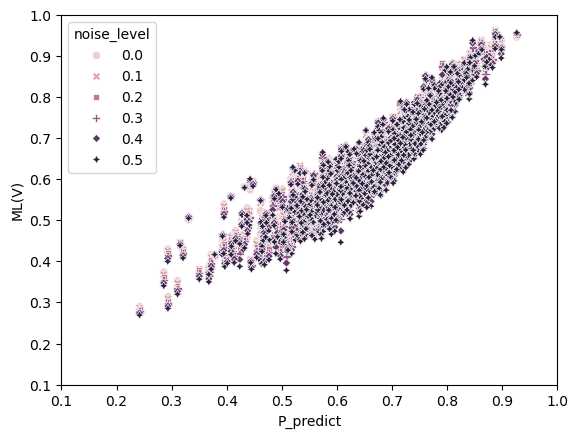

In [757]:
sns.scatterplot(data = data_analysis_all,x='P_predict', y='ML(V)' ,hue='noise_level',style='noise_level')

plt.xlim([0.1,1])
plt.ylim([0.1,1])

In [758]:
data_analysis_all['error'] = (data_analysis_all['ML(V)'] - data_analysis_all['P_predict'] ).abs()

In [759]:
data_analysis_all['cols'] = Cols_Num

In [760]:
data_analysis_all['ML(V)'].max()

0.9618287662404706

In [761]:
data_analysis_all['ML(V)'].min()

0.26929112261072247

In [762]:
data_analysis_all.to_csv('data_analysis_all_'+str(Cols_Num)+'_t_'+str(np.round(t_sample,2))+'_.csv')

In [763]:
ML_all_rand_all.to_csv('ML_all_rand_all_'+str(Cols_Num)+'_t_'+str(np.round(t_sample,2))+'_.csv')

<Axes: xlabel='noise_level', ylabel='error'>

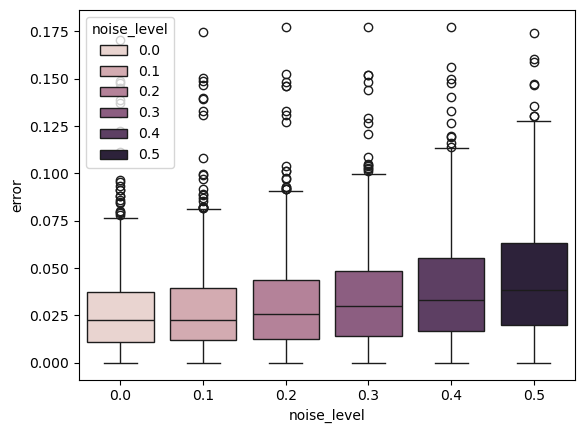

In [764]:

# plt.boxplot(data_analysis_all['ML(V)']-P_fit_rand)
sns.boxplot(data=data_analysis_all,y='error',x='noise_level',hue='noise_level')
# plt.xticks([1],' ')
# plt.ylabel('error')
# rmse = np.sqrt(np.power((P_fit_rand-data_random_sample['ML(V)']),2).mean())
# std = np.std(P_fit_rand-data_random_sample['ML(V)'])
# # rmse = np.sqrt(np.power((P_product_rand.values-data_random_sample['ML(V)'].values),2).mean())
# print('rmse=',rmse)
# print('std=',std)
# # plt.text(0.1,0.95*P_row.max(),'$r^2$='+str(np.round(r[0,1]**2,4)),fontsize=5)
# plt.text(1.1,rmse,'RMSE='+str(np.round(rmse,4)),fontsize=10)

<Axes: xlabel='noise_level', ylabel='error'>

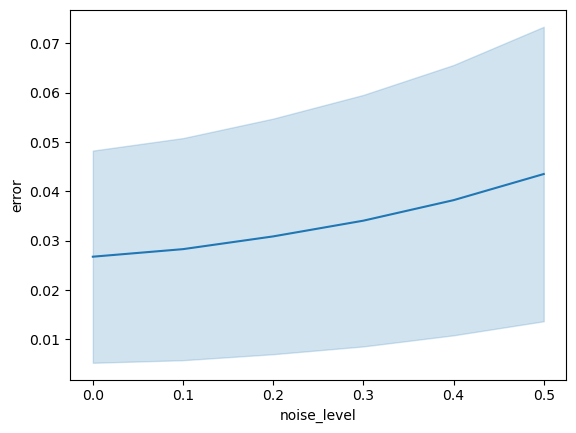

In [765]:
sns.lineplot(data=data_analysis_all,y='error',x='noise_level',errorbar='sd')
# plt.xscale('log')